In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to the drive location

In [2]:
cd drive/MyDrive/

/content/drive/MyDrive


In [3]:
import torch
from torchvision import datasets, models, transforms
import os
import numpy as np
import torch.optim as optim
import time
from torch.utils.data import Dataset, Subset
import copy
import torchvision

Define Model

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        numfts = self.model.fc.in_features
        #----------RESNET - 50
        #self.model.fc = nn.Sequential(nn.Linear(self.model_in_fetures,1000),nn.ReLU(),nn.Dropout(0.5),
        #      nn.Linear(1000,250),nn.ReLU(),nn.Dropout(0.5),
        #      nn.Linear(250,50),nn.ReLU(),nn.Dropout(0.5),
        #      nn.Linear(50,8))
        self.model.fc = nn.Linear(numfts,8)
        #----------RESNET - 18
        #self.model.fc = nn.Sequential(nn.Linear(numfts,250),nn.ReLU(),nn.Dropout(0.5),
        #                              nn.Linear(250,100),nn.ReLU(),nn.Dropout(0.5),
        #                              nn.Linear(100,50),nn.ReLU(),nn.Dropout(0.5),
        #                              nn.Linear(50,8))

    def forward(self, x):
        return  F.log_softmax(self.model(x),dim = 1)
        
    
    def save_model(self):
        
        torch.save(self.state_dict(), 'ankurraj1')


Tansformation for Training Dataset

In [5]:
trans = transforms.Compose([transforms.RandomRotation(25),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transNoAugment = transforms.Compose([transforms.Resize(255), 
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# https://discuss.pytorch.org/t/why-do-we-need-subsets-at-all/49391/7
# adapted from ptrblck post
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)
    
# Load entire dataset once
data_dir = 'data/data_extra/'
dataset = datasets.ImageFolder(data_dir)

traindataset = MyLazyDataset(dataset,trans)
valdataset = MyLazyDataset(dataset,transNoAugment)
testdataset = MyLazyDataset(dataset,transNoAugment)

In [6]:
len_subclass = []
num = 0
for j in range(0,8):
  for i in dataset.targets:
    if (i ==j):
      num+=1
  len_subclass.append(num)
  num = 0
print(len_subclass)
print(dataset.classes)

[1001, 1001, 1001, 1001, 1001, 1001, 1000, 1001]
['christmas_cookies', 'christmas_presents', 'christmas_tree', 'fireworks', 'penguin', 'reindeer', 'santa', 'snowman']


In [7]:
train_size = 0.8
num_train = len(traindataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

traindata = Subset(traindataset, indices=train_idx)
valdata = Subset(valdataset, indices=valid_idx)
testdata = Subset(testdataset, indices=test_idx)

num_workers = 5
batch_size = 8

if __name__ == '__main__':
    trainLoader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, 
                                              num_workers=num_workers, drop_last=True)
    valLoader = torch.utils.data.DataLoader(valdata, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True)
    testLoader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                             num_workers=num_workers, drop_last=True)

In [8]:
len(valdata)

801

In [9]:
split2

7206

In [10]:
dataset.classes
len(iter(valLoader).next())

2

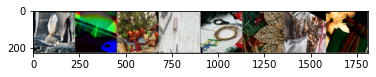

In [11]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainLoader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Send Network to GPU

In [ ]:
net = Network()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Define Loss Function

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

Function for training

In [15]:
def train_model(model,numEpoch,criterion,optimizer,scheduler):
  since = time.time()
  best_acc = 0
  
  for epoch in range(numEpoch):  # loop over the dataset multiple times
      #valcount = 0
      running_loss = 0.0
      train_total = 0.0
      train_correct = 0.0
      for data in trainLoader:
        model.train()
          # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

          # zero the parameter gradients
        optimizer.zero_grad()

          # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += torch.sum(predicted == labels.data)
        running_loss += loss.item() * inputs.size(0)
      
      scheduler.step()
      # print statistics
      epoch_acc_train = 100 * train_correct / train_total
      epoch_loss = running_loss/train_total
      print("train total [%d] " %(train_total))
      print('[%d] epoch loss : %.3f' %(epoch + 1,epoch_loss))
      print('[%d] train accuracy: %.3f' %(epoch + 1,epoch_acc_train))

      #####Validation Step
      val_correct = 0.0
      val_total = 0.0
      with torch.no_grad():
        model.eval()
        for data in valLoader:
            images, labels = data[0].to(device),data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        epoch_acc_val = 100 * val_correct / val_total
        print("val total [%d] " %(val_total))
        print('[%d] val accuracy: %.3f' %(epoch + 1,epoch_acc_val))
        if(epoch_acc_val > best_acc):
          best_model_wts = copy.deepcopy(model.state_dict())
          print('[%d] Increased Epoch Accuracy: %.3f' %
                    (epoch + 1, epoch_acc_val))
          best_acc = epoch_acc_val

        #if(currentValAccuracy > prevValidationAccuracy):
        #  print("Current Validation is more than previous for {0} pass : {1}".format(valcount+1,currentValAccuracy))
        #  valcount += 1
        #  if(valcount > 3):
        #    break

  endtime = time.time()
  print('Time Elapsed in mins - {0}'.format((endtime-since)/60))
  print('Finished Training')
  model.load_state_dict(best_model_wts)
  return model

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
epoch = 100
trained_model = train_model(net,epoch,criterion,optimizer,exp_lr_scheduler)

train total [6400] 
[1] epoch loss : 0.891
[1] train accuracy: 69.328
val total [800] 
[1] val accuracy: 79.375
[1] Increased Epoch Accuracy: 79.375
train total [6400] 
[2] epoch loss : 0.841
[2] train accuracy: 71.250
val total [800] 
[2] val accuracy: 80.250
[2] Increased Epoch Accuracy: 80.250
train total [6400] 
[3] epoch loss : 0.854
[3] train accuracy: 70.562
val total [800] 
[3] val accuracy: 81.375
[3] Increased Epoch Accuracy: 81.375
train total [6400] 
[4] epoch loss : 0.826
[4] train accuracy: 71.531
val total [800] 
[4] val accuracy: 79.250
train total [6400] 
[5] epoch loss : 0.806
[5] train accuracy: 72.562
val total [800] 
[5] val accuracy: 81.875
[5] Increased Epoch Accuracy: 81.875
train total [6400] 
[6] epoch loss : 0.797
[6] train accuracy: 73.031
val total [800] 
[6] val accuracy: 80.875
train total [6400] 
[7] epoch loss : 0.809
[7] train accuracy: 72.109
val total [800] 
[7] val accuracy: 82.125
[7] Increased Epoch Accuracy: 82.125
train total [6400] 
[8] epoch l

Saving Model

In [16]:
#torch.save(trained_model,'model100_epoch_resnet18_1linear')
trained_model = torch.load('model100_epoch_resnet18_1linear')

In [18]:
correct = 0
total = 0
with torch.no_grad():
  trained_model.eval()
  for data in testLoader:
      images, labels = data[0].to(device),data[1].to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on test dataset is : %d %%' % (
    100 * correct / total))

Accuracy of the network on test dataset is : 87 %


Storing and saving result in CSV





In [19]:
import glob
import re
from PIL import Image
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#net = model.Network().to(device)
#net.load_state_dict(torch.load('model'))
net = trained_model

net.eval()
filelist = glob.glob('data/val/*.png')
loader = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
prediction = torch.tensor([],dtype = torch.float).to(device)
i = 0
label = []

for fname in filelist:
    image = Image.open(fname).convert('RGB')
    image = loader(image).to(device)
    
    image = Variable(image)
    image = image.unsqueeze(0)
    pred_image = net(image)
    result_image = pred_image.argmax(dim = 1)
        
    prediction = torch.cat((prediction,result_image),dim = 0)
    prediction = prediction.int()
    fname2 = re.findall(r'\d+',fname)
    fname2 = list(map(int,fname2))
    label.append(fname2[0])

Resizing The images

In [ ]:
cd ..

/content/drive/My Drive


In [ ]:
def resize_image(foldername):
  from PIL import Image
  import glob
  source = 'data/train/'+foldername+ '/*.png'
  saveloc = 'data/data_extra/' + foldername
  for i , imagename in enumerate(glob.iglob(source)):
    image = Image.open(imagename)
    im_resize = image.resize((224,224), Image.ANTIALIAS)
    im_resize.save((saveloc + '/{0}' + ".png").format(i))
  print(foldername + " done")

#resize_image('snowman')
#resize_image('santa')
#resize_image('christmas_presents')
#resize_image('reindeer')
#resize_image('fireworks')
#resize_image('christmas_tree')
#resize_image('christmas_cookies')
#resize_image('penguin')

def more_data(foldername,num_image,num_end):
  from PIL import Image
  import glob
  source = 'data/train/'+ foldername + '/*.png'
  saveloc = 'data/data_extra/' + foldername
  exit_cond = False
  for i , imagename in enumerate(glob.iglob(source)):
    print(i)
    if (i <= num_image):
      image = Image.open(imagename)
      #im_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
      im_conv = image.convert('L')
      im_resize = im_conv.resize((224,224), Image.ANTIALIAS)
      im_resize.save((saveloc + '/{0}' + ".png").format(i+num_end))
  print(foldername + " done")

In [ ]:
#more_data("christmas_cookies",284,716)
#more_data("snowman",160,840)
#more_data("santa",88,1001)
#more_data("penguin",250,750)
#more_data("reindeer",239,761)
#more_data("christmas_presents",220,780)
#more_data("fireworks",244,756)
#more_data("christmas_tree",224,776)

In [ ]:
data_dir = 'data/data_extra/'
dataset = datasets.ImageFolder(data_dir)

def display_class_info():
  len_subclass = []
  num = 0
  for j in range(0,8):
    for i in dataset.targets:
      if (i == j):
        num+=1
    len_subclass.append(num)
    num = 0
  print(len_subclass)
  print(dataset.classes)
display_class_info()

[1001, 1001, 1001, 1001, 1001, 1001, 1000, 1001]
['christmas_cookies', 'christmas_presents', 'christmas_tree', 'fireworks', 'penguin', 'reindeer', 'santa', 'snowman']


In [ ]:
abc = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
len_subclass = [1001, 1001, 1001, 1001, 1001, 1001, 912, 1001]
np.array(abc) - np.array(len_subclass)

array([-1, -1, -1, -1, -1, -1, 88, -1])

In [20]:
#print(predten.argmax(dim = 1))
class_names_predicted  = []
prediction = prediction.to('cpu').numpy()
class_names = dataset.classes
label1 = label
for i in prediction:
  class_names_predicted.append(class_names[i])


In [21]:
import pandas as pd
data_val = pd.DataFrame({'Id':label1,'Category':prediction,'Predicted class Label':class_names_predicted})

In [22]:
data_val = data_val.sort_values('Id')
data_val.to_csv('test2.csv',index = False)

In [23]:
data_val

,Id,Category,Predicted class Label
148,0,7,snowman
86,1,5,reindeer
121,2,1,christmas_presents
98,3,5,reindeer
3,4,1,christmas_presents
...,...,...,...
7,155,0,christmas_cookies
80,156,5,reindeer
158,157,7,snowman
57,158,3,fireworks
